# Lesson 3: Function parameter approximation with automated gradient descent

In this lesson we dove deeper into the foundations of Neurel Nets, covering the composition of layers, activation functions, and gradient descent. In this mini-project we will go through an example of how we can approximate a function's parameters using gradient descent.

In the lecture, we saw how to fit a model to a simple quadratic function. In this mini-project, I'll try to fit a model to a multivariable function instead. This is a good exercise as oftentimes in the real world we will be trying to create a model with multiple inputs (features).

Let's start by defining a bivariate function we'd like to model.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from functools import partial

In [15]:
def bivariate_fn(coeffs, x, y):
    return (coeffs[0] * x**2 * y**2) + (coeffs[1] * x**2 * y) + \
           (coeffs[2] * x**2) + (coeffs[3] * x * y**2) + \
           (coeffs[4] * x * y) + (coeffs[5] * x) + \
           (coeffs[6] * y**2) + (coeffs[7] * y) + coeffs[8]

def make_bivariate(coeffs):
    return partial(bivariate_fn, coeffs)

f = make_bivariate([0.25, 0.0, 0.25, 1, 0.25, -0.1, 0.0, -1.0, -1])

f(1,0.5)

-0.9125

We've defined a function that takes in two inputs, x and y, and returns a single value. We've used a partial to allow us to specify the coefficients. In this exercise, we'll generate some noisy data with a particular set of coeffecients, and then try to fit a model in order to see if we can approximate the coefficients.

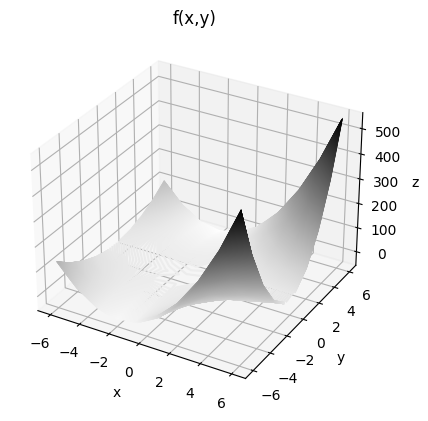

In [23]:
x = np.linspace(-6, 6, 10)
y = np.linspace(-6, 6, 10)

X, Y = np.meshgrid(x,y)
Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 1000, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('f(x,y)')
plt.show()

Next, we'll generate some data points by adding noise to the function output. We'll use these datapoints to fit a model.

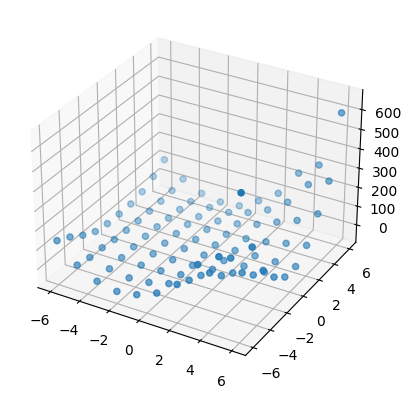

In [55]:
from numpy.random import normal,seed,uniform
import torch

np.random.seed(98)
def noise(z, scale):
    return normal(scale=scale, size=x.shape)

def add_noise(z, mult, add):
    return z * (1 + noise(z,mult)) + noise(z,add)


x,y = torch.meshgrid(torch.linspace(-6, 6, 10), torch.linspace(-6, 6, 10))

z = add_noise(f(x,y), 0.1, 1.1)
ax = plt.axes(projection='3d')
ax.scatter3D(x.numpy(), y.numpy(), z.numpy())
plt.show()

Ultimately what we'd like to achieve here is to back out the original polynomial coefficients. One method we could use this is manually adjusting them until the surface seems to fit the data, like we did in lecture. This will prove to be more difficult than it was in lecture, given that we have 9 polynomial coefficients instead of 3 -- the surface is quite a bit more complex.

We can use a loss function to measure how close our parameters are to approximating the true values.

In [60]:
from ipywidgets import interact

def mae(preds, acts): 
    return (torch.abs(preds-acts)).mean()


@interact(a=1.1, b=1.1, c=1.1, d=1.1, e=1.1, f=1.1, g=1.1, h=1.1, i=1.1)
def plot_bivariate(a, b, c, d, e, f, g, h, i):
    fn = make_bivariate([a, b, c, d, e, f, g, h, i])
    ax = plt.axes(projection='3d')
    zp = fn(x,y)
    ax.scatter3D(x.numpy(), y.numpy(), z.numpy())
    ax.contour3D(x.numpy(), y.numpy(), zp.numpy(), 200, cmap='binary')
    loss = mae(zp, z)
    ax.set_title('Loss: ' + f"MAE: {loss:.2f}")
    plt.show()

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

This is of course a pretty difficult task for a human, a complex 3d surface like this is hard to visualize and even more difficult to manipulate. Even when given the MAE value it's difficult to get the parameters in their correct spots. We can instead use *gradient descent* to put these parameters in their proper places! (If this plot renders properly, we achieved an MSE of 12.89 through manual adjustment).

One strategy to use while manually adjusting the parameter values is to move them in the direction that makes the loss value go down. As we discussed in lecture, this is the core idea behind gradient descent! Instead of playing around with interactive dials, we can calculate the gradient of our loss function with respect to each parameter, and then move the paremeters in the opposite direction to the sign of the gradient.

In [67]:
def bivariate_mae(params):
    fn = make_bivariate(params)
    zp = fn(x,y)
    return mae(zp, z)

Here's a function that will let us get the MAE for a set of parameters. Let's make an initial guess, at the parameters to see what our MAE value is currently at.

In [76]:
guess = torch.tensor([1,1,1,1,1,1,1,1,1]).float()
guess.requires_grad_()

loss = bivariate_mae(guess)
loss

tensor(188.6029, dtype=torch.float64, grad_fn=<MeanBackward0>)

Now we can get the gradients by running *loss.backward()*. This will store the gradients in the .grad attribute of our parameter tensor.

In [77]:
loss.backward()
guess.grad

tensor([ 2.1511e+02,  5.9257e-03,  1.4658e+01,  5.9260e-03, -8.8890e-03,
         1.3333e-02,  1.4658e+01,  1.3333e-02,  9.8000e-01])

As we said before, we want to move our parameters in the direction opposite the sign of the gradient. In this case all our gradient values are positive, so we'd want to decrease the values of every paremeter by a small amount. If the gradient of some parameters was negative, we'd want to increase those values by a small amount. 

We can automate this process:

In [80]:
num_steps = 20
adj_rate = 0.01

def gradient_descent(steps, rate, guess):
    for i in range(steps):
        loss = bivariate_mae(guess)
        loss.backward()
        with torch.no_grad():
            guess -= guess.grad * rate
        print(guess)
        print(f"Step {i}: {loss:.2f}")

gradient_descent(num_steps, adj_rate, guess)

tensor([-3.3021,  0.9999,  0.7068,  0.9999,  1.0002,  0.9997,  0.7068,  0.9997,
         0.9804], requires_grad=True)
Step 0: 188.60
tensor([-5.4582,  0.9941,  0.5525,  0.9974,  0.9986,  0.9973,  0.5561,  0.9973,
         0.9692], requires_grad=True)
Step 1: 746.03
tensor([-5.4633,  0.9881,  0.5447,  0.9949,  0.9970,  0.9949,  0.5518,  0.9947,
         0.9676], requires_grad=True)
Step 2: 1213.91
tensor([-3.3173,  0.9821,  0.6834,  0.9924,  0.9954,  0.9925,  0.6940,  0.9917,
         0.9756], requires_grad=True)
Step 3: 1215.18
tensor([0.9751, 0.9705, 0.9610, 0.9870, 0.9917, 0.9879, 0.9795, 0.9871, 0.9922],
       requires_grad=True)
Step 4: 749.78
tensor([3.1164, 0.9589, 1.0920, 0.9816, 0.9882, 0.9831, 1.1183, 0.9823, 0.9990],
       requires_grad=True)
Step 5: 182.36
tensor([3.1066, 0.9473, 1.0764, 0.9761, 0.9847, 0.9781, 1.1106, 0.9773, 0.9960],
       requires_grad=True)
Step 6: 646.93
tensor([0.9458, 0.9355, 0.9143, 0.9705, 0.9813, 0.9731, 0.9563, 0.9723, 0.9832],
       requires_

Wow, that didn't work at all! Our loss value bounces around dramatically. Perhaps the adjustments we are making are too large.
Let's try again:

In [85]:
guess = torch.tensor([1,-1,1,-1,1,-1,1,-1,1]).float()
guess.requires_grad_()

adj_rate = 0.0001

gradient_descent(num_steps, adj_rate, guess)

tensor([0.9785, 1.0000, 0.9985, 1.0000, 1.0000, 1.0000, 0.9985, 1.0000, 0.9999],
       requires_grad=True)
Step 0: 188.60
tensor([0.9355, 1.0000, 0.9956, 1.0000, 1.0000, 1.0000, 0.9956, 1.0000, 0.9997],
       requires_grad=True)
Step 1: 183.93
tensor([0.8709, 1.0000, 0.9912, 1.0000, 1.0000, 1.0000, 0.9912, 1.0000, 0.9994],
       requires_grad=True)
Step 2: 174.59
tensor([0.7849, 1.0000, 0.9853, 1.0000, 1.0000, 1.0000, 0.9853, 1.0000, 0.9990],
       requires_grad=True)
Step 3: 160.58
tensor([0.6773, 1.0000, 0.9780, 1.0000, 1.0000, 1.0000, 0.9780, 1.0000, 0.9985],
       requires_grad=True)
Step 4: 141.90
tensor([0.5483, 1.0000, 0.9692, 1.0000, 1.0000, 1.0000, 0.9692, 1.0000, 0.9979],
       requires_grad=True)
Step 5: 118.56
tensor([0.3983, 0.9997, 0.9592, 1.0001, 1.0000, 1.0000, 0.9590, 0.9999, 0.9973],
       requires_grad=True)
Step 6: 90.87
tensor([0.2388, 0.9964, 0.9485, 1.0013, 0.9997, 1.0000, 0.9478, 0.9998, 0.9965],
       requires_grad=True)
Step 7: 65.61
tensor([0.0783, 0.

Closer this time! We see our loss go down but then come back up again, this is the phenomenon of overshooting we discussed in lecture. We can try to fix this by decreasing our learning rate over time. Normally a framework would automate this for us.

Let's try decreasing the learning rate by a small amount every iteration.



In [104]:
def gradient_descent(steps, rate, guess):
    for i in range(steps):
        loss = bivariate_mae(guess)
        loss.backward()
        with torch.no_grad():
            guess -= guess.grad * rate
        print(guess)
        print(f"Step {i}: {loss:.2f}")
        rate = rate * 0.8

guess = torch.tensor([1,1,1,1,1,1,1,1,1]).float()
guess.requires_grad_()

adj_rate = 0.0001
num_steps = 20

gradient_descent(num_steps, adj_rate, guess)

tensor([0.9785, 1.0000, 0.9985, 1.0000, 1.0000, 1.0000, 0.9985, 1.0000, 0.9999],
       requires_grad=True)
Step 0: 188.60
tensor([0.9441, 1.0000, 0.9962, 1.0000, 1.0000, 1.0000, 0.9962, 1.0000, 0.9997],
       requires_grad=True)
Step 1: 183.93
tensor([0.9028, 1.0000, 0.9934, 1.0000, 1.0000, 1.0000, 0.9934, 1.0000, 0.9996],
       requires_grad=True)
Step 2: 176.46
tensor([0.8587, 1.0000, 0.9904, 1.0000, 1.0000, 1.0000, 0.9904, 1.0000, 0.9994],
       requires_grad=True)
Step 3: 167.49
tensor([0.8147, 1.0000, 0.9874, 1.0000, 1.0000, 1.0000, 0.9874, 1.0000, 0.9992],
       requires_grad=True)
Step 4: 157.93
tensor([0.7724, 1.0000, 0.9845, 1.0000, 1.0000, 1.0000, 0.9845, 1.0000, 0.9990],
       requires_grad=True)
Step 5: 148.36
tensor([0.7329, 1.0000, 0.9818, 1.0000, 1.0000, 1.0000, 0.9818, 1.0000, 0.9988],
       requires_grad=True)
Step 6: 139.18
tensor([0.6968, 1.0000, 0.9794, 1.0000, 1.0000, 1.0000, 0.9793, 1.0000, 0.9986],
       requires_grad=True)
Step 7: 130.62
tensor([0.6643, 

Nice! We see our loss value go down gradually. Now let's see if we can run for more steps to get our loss even lower.

In [123]:
def gradient_descent(steps, rate, guess, print_every=10):
    for i in range(steps):
        loss = bivariate_mae(guess)
        loss.backward()
        with torch.no_grad():
            guess -= guess.grad * rate
        if i % print_every == 0:
            print(f"Step {i}: {loss:.2f}")
        rate = rate * 0.8

guess = torch.tensor([1,1,1,1,1,1,1,1,1]).float()
guess.requires_grad_()

adj_rate = 0.0001
num_steps = 100

gradient_descent(num_steps, adj_rate, guess)

Step 0: 188.60
Step 10: 109.48
Step 20: 79.49
Step 30: 74.59
Step 40: 74.00
Step 50: 73.93
Step 60: 73.92
Step 70: 73.92
Step 80: 73.92
Step 90: 73.92


Perhaps our rate is too low, we can also try bumping it up a bit.

In [124]:
def gradient_descent(steps, rate, dr, guess, print_every=70):
    for i in range(steps):
        loss = bivariate_mae(guess)
        loss.backward()
        with torch.no_grad():
            guess -= guess.grad * rate
        
        if i % print_every == 0:
            print(f"Step {i}: {loss:.2f}")
        rate = rate * dr

guess = torch.tensor([1,1,1,1,1,1,1,1,1]).float()
guess.requires_grad_()

adj_rate = 0.0001
dr = 0.985
num_steps = 700

gradient_descent(num_steps, adj_rate, dr, guess)

Step 0: 188.60
Step 70: 65.56
Step 140: 59.43
Step 210: 37.27
Step 280: 14.95
Step 350: 25.03
Step 420: 19.72
Step 490: 18.83
Step 560: 13.13
Step 630: 11.10


By adjusting our rate a little more, I was able to get a more precise approximation of our original function than I could achieve by hand! 
Modern frameworks use more sophisticated methods to adjust the gradient descent process automatically, but our experiment illustrates the basic idea!